In [32]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

import pymanopt
import pymanopt.manifolds
import pymanopt.solvers
# from pymanopt.solvers import TrustRegions

from numpy.random import default_rng

import networkx as nx

In [33]:
def cost(Y):
    return -1/4 * np.trace(Y @ Y.T @ L)

In [34]:
def hyperplane_rounding(Y, cost, iter=100):
    min_cost = 0
    best_x = None
    d = Y.shape[1]
    rng = default_rng()
    for i in range(iter):
        r = rng.random((d,1))
        r = r / np.linalg.norm(r)
        x = np.sign(Y @ r)
        cost_val = cost(x)
        if cost_val < min_cost:
            min_cost = cost_val
            best_x = x
    return best_x, min_cost

In [35]:
def iterate_elliptope(rank, n, L, initial_Y=None):
    print("Current rank: %s"  %(rank))
    manifold = pymanopt.manifolds.Elliptope(n, rank)

    @pymanopt.function.Autograd(manifold)
    def manifold_cost(Y):
        return -1/4 * np.trace(Y @ Y.T @ L)

    problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
    solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
    solution = solver.solve(problem)

    return solution, manifold_cost(solution)

In [36]:
def reduce_rank(Y, normalize_rows):
    X = Y @ Y.T
    rank = np.linalg.matrix_rank(X, tol=1e-6) - 1
    Y_proj = None
    if rank >= 1:
        eigen_values, eigen_vectors = np.linalg.eig(X)
        eigen_values = np.real(eigen_values)
        eigen_vectors = np.real(eigen_vectors)
        Y_proj = eigen_vectors[:, range(rank)] @ np.diag(np.sqrt(eigen_values[range(rank)]))  # FIXME: don't assume it's sorted
        if normalize_rows:
            Y_proj = Y_proj / np.linalg.norm(Y_proj, axis=1)[:, np.newaxis]
    return Y_proj, rank

### Data

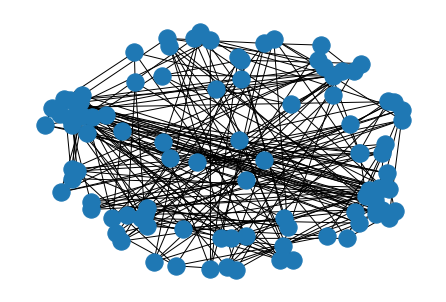

In [37]:
data_path = "../dat/"
# graph_file = "torusg3-8.dat"
graph_file = "toruspm3-8-50.dat"

with open(data_path + graph_file) as inf:
    next(inf, '')   # skip first line
    G = nx.read_weighted_edgelist(inf, nodetype=int, encoding="utf-8")

nx.draw(G.subgraph(range(100)))

In [61]:
n = len(G)
L = nx.laplacian_matrix(G).toarray() * 1.0
opt_sdp_rank = 34  # the optimal solution from the original BM method paper is 33

In [62]:
normalize_rows = True

## Solve SDP relaxation

In [63]:
sdp_solution, sdp_cost = iterate_elliptope(opt_sdp_rank, n, L)

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -1.6708962942771506e+00    2.74808594e+01    
   2         -2.9088981260889241e+01    2.73808120e+01    
   3         -1.3430034266151142e+02    2.55795101e+01    
   4         -3.5921127272283536e+02    1.52701547e+01    
   5         -4.2095349553630524e+02    1.76412875e+01    
   6         -4.6799259531094879e+02    8.76449295e+00    
   7         -4.7719535646288858e+02    1.04318142e+01    
   8         -4.9236775048966888e+02    4.97754855e+00    
   9         -4.9728433033386096e+02    6.10800906e+00    
  10         -4.9982084310863087e+02    6.93969856e+00    
  11         -5.0599545869106305e+02    2.48662313e+00    
  12         -5.1116168909452063e+02    5.51884729e+00    
  13         -5.1463331284241985e+02    2.72626919e+00    
  14         -5.1556271300358048e+02    2.69336008e+00    
  15         -5.161724269

In [70]:
np.linalg.svd(sdp_solution)

(array([[-0.05677276, -0.05433329,  0.00979498, ..., -0.0099947 ,
         -0.00156917, -0.03279132],
        [-0.03534524, -0.05087719,  0.03421102, ...,  0.06755782,
         -0.02249555, -0.03813932],
        [ 0.0080668 ,  0.03963605, -0.06764197, ...,  0.04259561,
         -0.0593108 , -0.02787363],
        ...,
        [ 0.04165752, -0.07038774, -0.01114517, ...,  0.94970868,
          0.03644389, -0.00099144],
        [-0.04484066,  0.07871785, -0.01488206, ...,  0.03349494,
          0.96326154,  0.00436296],
        [-0.01555243, -0.07668694, -0.02809111, ..., -0.00245107,
          0.00795345,  0.9449059 ]]),
 array([1.09003255e+01, 1.02016209e+01, 8.93140940e+00, 8.32120041e+00,
        6.96233121e+00, 6.22996164e+00, 5.97828548e+00, 2.75707920e+00,
        2.49845210e+00, 1.51625667e+00, 8.32903573e-01, 3.18387629e-01,
        2.91612415e-01, 1.54131711e-01, 1.21082072e-01, 7.85273938e-02,
        4.60510205e-02, 3.24876457e-02, 1.30510354e-02, 8.18529053e-03,
        7.104

## Manifold iteration

### Start from SDP solution

In [41]:
manifold_iteration_ranks = []
manifold_iteration_costs = []

In [42]:
Y_new, rank_new = reduce_rank(sdp_solution, normalize_rows)

In [43]:
while(rank_new > 1):
    solution, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    manifold_iteration_ranks += [rank_new]
    manifold_iteration_costs += [-cost_val]
    Y_new, rank_new = reduce_rank(solution, normalize_rows)

Current rank: 32
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +3.8686279319148387e-01    2.70045665e+01    
   2         -2.6558977654043105e+01    2.69129977e+01    
   3         -1.3002264490708774e+02    2.51883971e+01    
   4         -3.5319173797047290e+02    1.52992315e+01    
   5         -4.1924780916277814e+02    1.73139572e+01    
   6         -4.6240243425073464e+02    1.05665072e+01    
   7         -4.8069325348858570e+02    6.53356725e+00    
   8         -4.8276140407626121e+02    1.16403586e+01    
   9         -4.9009089972512061e+02    9.01703317e+00    
  10         -5.0020157222369710e+02    4.99704124e+00    
  11         -5.0436269496447704e+02    3.87890766e+00    
  12         -5.0697963433833905e+02    4.52172869e+00    
  13         -5.0868586065659224e+02    5.07614735e+00    
  14         -5.1219653398044898e+02    2.02041314e+00    
  15         -5.152137238

In [44]:
_, manifold_iteration_cost = hyperplane_rounding(solution, cost)
manifold_iteration_simple_rounding_cost = cost(np.sign(Y_new))
manifold_iteration_ranks += [1, 1]
manifold_iteration_costs += [-manifold_iteration_cost, -manifold_iteration_simple_rounding_cost]

### Start from random point

In [45]:
manifold_iteration_random_start_ranks = []
manifold_iteration_random_start_costs = []
_, rank_new = reduce_rank(sdp_solution, normalize_rows)
Y_new = None
while (rank_new > 1):
    solution, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    manifold_iteration_random_start_ranks += [rank_new]
    manifold_iteration_random_start_costs += [-cost_val]
    Y_new, rank_new = reduce_rank(solution, normalize_rows)
_, manifold_iteration_random_start_cost = hyperplane_rounding(solution, cost)
manifold_iteration_random_start_simple_rounding_cost = cost(np.sign(Y_new))
manifold_iteration_random_start_ranks += [1, 1]
manifold_iteration_random_start_costs += [-manifold_iteration_random_start_cost, -manifold_iteration_random_start_simple_rounding_cost]

Current rank: 32
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -3.5546548064185224e+00    2.69567075e+01    
   2         -3.0446802375542273e+01    2.68531005e+01    
   3         -1.3358777194762439e+02    2.50688928e+01    
   4         -3.5403365238225251e+02    1.51139059e+01    
   5         -4.1739333201675191e+02    1.74230673e+01    
   6         -4.6282673968865265e+02    9.53880994e+00    
   7         -4.7687064604853828e+02    8.56527941e+00    
   8         -4.8842522908155786e+02    5.49099342e+00    
   9         -4.9105827313581256e+02    8.96645681e+00    
  10         -4.9901536183063001e+02    4.79613387e+00    
  11         -4.9937793336814394e+02    7.66202469e+00    
  12         -5.0076029111761920e+02    6.94784931e+00    
  13         -5.0510246791294418e+02    4.09215778e+00    
  14         -5.0707631293107499e+02    4.52501152e+00    
  15         -5.097518079

### Repeat above without normalizing rows of rank-reduced matrix

In [46]:
normalize_rows = False

In [47]:
manifold_iteration_not_normalized_ranks = []
manifold_iteration_not_normalized_costs = []
Y_new, rank_new = reduce_rank(sdp_solution, normalize_rows)
while (rank_new > 1):
    solution, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    manifold_iteration_not_normalized_ranks += [rank_new]
    manifold_iteration_not_normalized_costs += [-cost_val]
    Y_new, rank_new = reduce_rank(solution, normalize_rows)
_, manifold_iteration_not_normalized_cost = hyperplane_rounding(solution, cost)
manifold_iteration_not_normalized_simple_rounding_cost = cost(np.sign(Y_new))
manifold_iteration_not_normalized_ranks += [1, 1]
manifold_iteration_not_normalized_costs += [-manifold_iteration_not_normalized_cost, -manifold_iteration_not_normalized_simple_rounding_cost]

Current rank: 32
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +1.2532256491740839e+00    2.74384136e+01    
   2         -2.6134949778364735e+01    2.73631640e+01    
   3         -1.3142657462118805e+02    2.56536492e+01    
   4         -3.5854235678943559e+02    1.52379318e+01    
   5         -4.2370117576160521e+02    1.75326872e+01    
   6         -4.6782331818941543e+02    1.00092511e+01    
   7         -4.8305652561355419e+02    7.57216761e+00    
   8         -4.9022330609221433e+02    7.98233393e+00    
   9         -4.9694886132990877e+02    6.82096366e+00    
  10         -4.9734295256650478e+02    8.94474655e+00    
  11         -4.9885959039789861e+02    8.26917548e+00    
  12         -5.0389407951926285e+02    5.52231956e+00    
  13         -5.0821902165280130e+02    3.02324711e+00    
  14         -5.0866157471126934e+02    6.37042042e+00    
  15         -5.102790849

In [48]:
manifold_iteration_random_start_not_normalized_ranks = []
manifold_iteration_random_start_not_normalized_costs = []
_, rank_new = reduce_rank(sdp_solution, normalize_rows)
Y_new = None
while (rank_new > 1):
    solution, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    manifold_iteration_random_start_not_normalized_ranks += [rank_new]
    manifold_iteration_random_start_not_normalized_costs += [-cost_val]
    Y_new, rank_new = reduce_rank(solution, normalize_rows)
_, manifold_iteration_random_start_not_normalized_cost = hyperplane_rounding(solution, cost)
manifold_iteration_random_start_not_normalized_simple_rounding_cost = cost(np.sign(Y_new))
manifold_iteration_random_start_not_normalized_ranks += [1, 1]
manifold_iteration_random_start_not_normalized_costs += [-manifold_iteration_random_start_cost, -manifold_iteration_random_start_simple_rounding_cost]

Current rank: 32
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -8.3774702032930382e+00    2.73355887e+01    
   2         -3.5646252392075127e+01    2.72271659e+01    
   3         -1.4019141888468403e+02    2.53867784e+01    
   4         -3.6168808011582894e+02    1.50950353e+01    
   5         -4.2015487928247660e+02    1.80001783e+01    
   6         -4.7072010712485826e+02    7.53486095e+00    
   7         -4.7440040638978542e+02    1.31697402e+01    
   8         -4.8681638945784806e+02    9.11560369e+00    
   9         -4.9858039823217598e+02    3.70579497e+00    
  10         -5.0359088892464922e+02    5.54647435e+00    
  11         -5.0793193672034431e+02    2.98688526e+00    
  12         -5.0839779974529944e+02    6.42978562e+00    
  13         -5.1009482857421062e+02    5.29153195e+00    
  14         -5.1371333942892977e+02    1.74731411e+00    
  15         -5.179650690

### Start from random point with lower rank

In [49]:
normalize_rows = True

In [50]:
manifold_iteration_low_rank_ranks = []
manifold_iteration_low_rank_costs = []
rank_new = 5
Y_new = None
while (rank_new > 1):
    solution, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    manifold_iteration_low_rank_ranks += [rank_new]
    manifold_iteration_low_rank_costs += [-cost_val]
    Y_new, rank_new = reduce_rank(solution, normalize_rows)
_, manifold_iteration_low_rank_cost = hyperplane_rounding(solution, cost)
manifold_iteration_low_rank_simple_rounding_cost = cost(np.sign(Y_new))
manifold_iteration_low_rank_ranks += [1, 1]
manifold_iteration_low_rank_costs += [-manifold_iteration_low_rank_cost, -manifold_iteration_low_rank_simple_rounding_cost]

Current rank: 5
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +6.7594658334069129e+00    2.49412957e+01    
   2         -1.8117094297039479e+01    2.48511257e+01    
   3         -1.1317309178901915e+02    2.32648924e+01    
   4         -3.1722501998448121e+02    1.54576468e+01    
   5         -3.3540843617220628e+02    2.45846841e+01    
   6         -3.9742044420217712e+02    1.76114126e+01    
   7         -4.0634078966693971e+02    2.07559190e+01    
   8         -4.3748901127749059e+02    1.55615242e+01    
   9         -4.6140737111548702e+02    1.22939372e+01    
  10         -4.8321577260114674e+02    4.52015351e+00    
  11         -4.8655940815676416e+02    9.01927134e+00    
  12         -4.9577627863483440e+02    3.77791528e+00    
  13         -4.9781240949237377e+02    5.16833477e+00    
  14         -5.0164563999418641e+02    2.41645035e+00    
  15         -5.0253814980

In [51]:
normalize_rows = False

In [52]:
manifold_iteration_low_rank_not_normalized_ranks = []
manifold_iteration_low_rank_not_normalized_costs = []
rank_new = 5
Y_new = None
while (rank_new > 1):
    solution, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    manifold_iteration_low_rank_not_normalized_ranks += [rank_new]
    manifold_iteration_low_rank_not_normalized_costs += [-cost_val]
    Y_new, rank_new = reduce_rank(solution, normalize_rows)
_, manifold_iteration_low_rank_not_normalized_cost = hyperplane_rounding(solution, cost)
manifold_iteration_low_rank_not_normalized_simple_rounding_cost = cost(np.sign(Y_new))
manifold_iteration_low_rank_not_normalized_ranks += [1, 1]
manifold_iteration_low_rank_not_normalized_costs += [-manifold_iteration_low_rank_not_normalized_cost, -manifold_iteration_low_rank_not_normalized_simple_rounding_cost]

Current rank: 5
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +6.6948137073958573e+00    2.50362960e+01    
   2         -1.8269566891608939e+01    2.49308389e+01    
   3         -1.1352545544593814e+02    2.32539228e+01    
   4         -3.1331633125586086e+02    1.48199874e+01    
   5         -3.2697713975028046e+02    2.48229604e+01    
   6         -3.7608918426401567e+02    1.99553292e+01    
   7         -4.4606177631959275e+02    1.11781612e+01    
   8         -4.6200950870795219e+02    1.10560726e+01    
   9         -4.7290293729815119e+02    1.06026066e+01    
  10         -4.8722515676803664e+02    6.32556203e+00    
  11         -4.9395584026228164e+02    4.02358248e+00    
  12         -4.9730405478231972e+02    6.64878216e+00    
  13         -5.0329873873606442e+02    2.86486207e+00    
  14         -5.0571538674533429e+02    4.07719809e+00    
  15         -5.0603125636

## Benchmark: hyperplane rounding of SDP solution

In [53]:
_, hyperplane_rounding_cost= hyperplane_rounding(sdp_solution, cost)

### Benchmark: greedy one-exchange

In [54]:
from networkx.algorithms.approximation import maxcut
one_exchange_cost = maxcut.one_exchange(G, weight="weight", initial_cut=None)[0]

## Plots

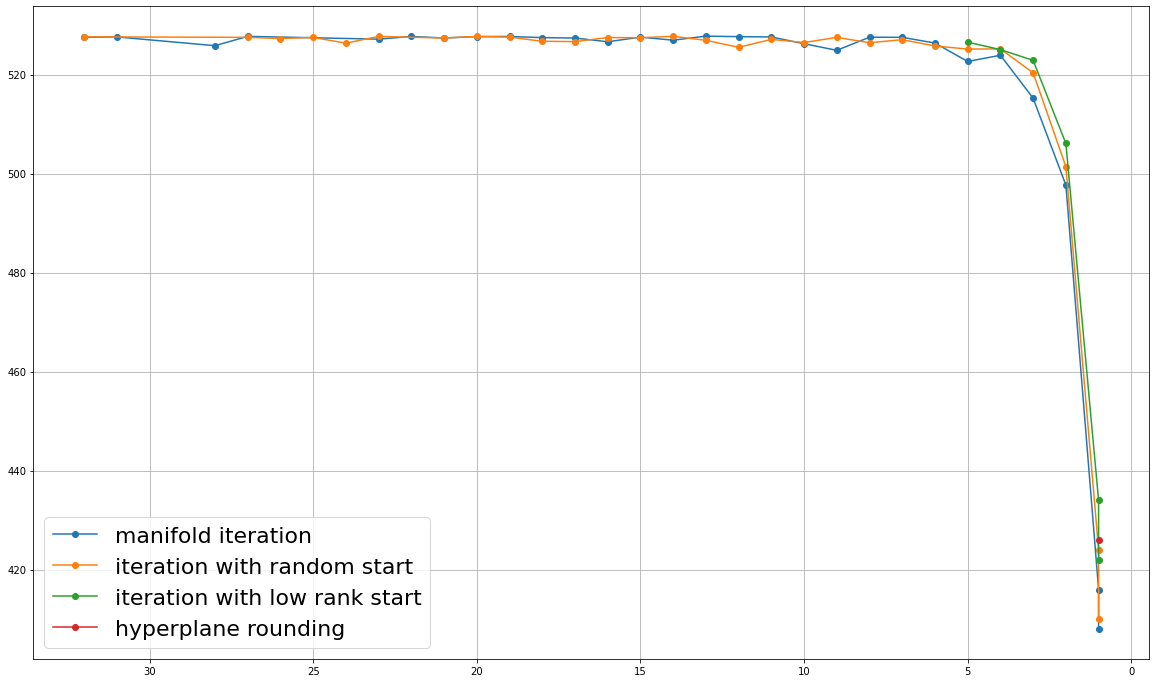

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
ax.invert_xaxis()

plt.plot(manifold_iteration_ranks, manifold_iteration_costs, label="manifold iteration", marker="o")
plt.plot(manifold_iteration_random_start_ranks, manifold_iteration_random_start_costs, label="iteration with random start", marker="o")
# plt.plot(manifold_iteration_not_normalized_ranks, manifold_iteration_not_normalized_costs, label="manifold iteration, not normalized", marker="o")
# plt.plot(manifold_iteration_random_start_not_normalized_ranks, manifold_iteration_random_start_not_normalized_costs, label="iteration with random start, not normalized", marker="o")
plt.plot(manifold_iteration_low_rank_ranks, manifold_iteration_low_rank_costs, label="iteration with low rank start", marker="o")
# plt.plot(manifold_iteration_low_rank_not_normalized_ranks, manifold_iteration_low_rank_not_normalized_costs, label="iteration with low rank start, not normalized", marker="o")

plt.plot([1], [-hyperplane_rounding_cost], label="hyperplane rounding", marker="o")
# plt.plot([1], [one_exchange_cost], label="one exchange", marker="o")

plt.legend(loc='lower left', fontsize=22)
plt.grid()